In [95]:
import seaborn as sns
import pickle 


In [96]:
import pandas as pd
import numpy as np

In [97]:
pd.set_option('display.max_rows', 200)

In [98]:
year19_path_list=  ['turnstile_190504.txt', 'turnstile_190511.txt','turnstile_190518.txt','turnstile_190525.txt']
year18_path_list=  ['turnstile_180505.txt', 'turnstile_180512.txt','turnstile_180519.txt','turnstile_180526.txt']

In [99]:
def load_data(list_of_datasets):
    year = pd.concat(map(lambda x: pd.read_csv(x,parse_dates=[['DATE','TIME']]), 
        list_of_datasets))
    return year

In [100]:
def preprocessing(dataframe):
    dataframe.reset_index(drop=True,inplace=True)
    dataframe.drop(['C/A','LINENAME','DIVISION', 'DESC'],axis=1,inplace = True)
    dataframe['UNIT/SCP']= dataframe['UNIT'] + dataframe['SCP'] #creating an ideantifier column 
    dataframe =  dataframe[(dataframe['DATE_TIME'].dt.month > 4)]
    dataframe = dataframe.sort_values(['STATION', 'UNIT/SCP','DATE_TIME'], ascending= True)
    return  dataframe
    

In [101]:
def calculate_entries_column(dataframe):
    dataframe.reset_index(drop=True,inplace=True)
    dataframe['ENTRIES_DIFF']=0
    for index, row in dataframe.iterrows():
        if index == 0:
            continue
        if row['UNIT/SCP'] == dataframe['UNIT/SCP'][index-1] and row['STATION'] == dataframe['STATION'][index-1] and row['ENTRIES'] > int(dataframe['ENTRIES'][index-1]):
            dataframe['ENTRIES_DIFF'][index] = row['ENTRIES'] - int(dataframe['ENTRIES'][index-1])
            
    return dataframe

In [129]:
def calculate_exits_column(dataframe):
    dataframe.columns=dataframe.columns.str.strip()
    dataframe.reset_index(drop=True,inplace=True)
    dataframe['EXITS_DIFF']=0
    for index, row in dataframe.iterrows():
        if index == 0:
            continue
        if row['UNIT/SCP'] == dataframe['UNIT/SCP'][index-1] and row['STATION'] == dataframe['STATION'][index-1] and row['EXITS'] > int(dataframe['EXITS'][index-1]):
            dataframe['EXITS_DIFF'][index] = row['EXITS'] - int(dataframe['EXITS'][index-1])
            
    return dataframe

In [103]:
def calculate_total_traffic(dataframe):
    dataframe['TOTAL_TRAFFIC']= dataframe['ENTRIES_DIFF'] + dataframe['EXITS_DIFF']
    return dataframe

In [104]:
def generate_stat(dataframe):
    year19_traffic_per_station = dataframe.groupby('STATION').TOTAL_TRAFFIC.sum()
    year19_traffic_per_station = pd.DataFrame(year19_traffic_per_station)
    sorted_traffic = year19_traffic_per_station.sort_values(by=['TOTAL_TRAFFIC'], ascending= False)
    return sorted_traffic

In [105]:
def pickle_df(dataframe):
    with open("MTA_19.pickle","wb")as to_write:
        pickle.dump(dataframe,to_write)

In [125]:
def read_pickle(file_name):
    with open(file_name, 'rb') as f:
        dataframe = pickle.load(f)
        return dataframe

In [127]:
def init_dataframe(years_list):
    year=load_data(years_list)
    year = preprocessing(year)
    year = calculate_entries_column(year)
    year = calculate_exits_column(year)
    return year 

In [148]:
def graph_stats(stats):
    stats = stats.head(5)
    stats = stats.reset_index()
    stats.columns
    sns.barplot(x=stats['TOTAL_TRAFFIC'], y=stats['STATION'])

In [10]:
year19=load_data(year19_path_list)

In [11]:
year19 = preprocessing(year19)

In [12]:
year19 = calculate_entries_column(year19)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
year19 = calculate_exits_column(year19)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [14]:
#HANDLING OUTLIERS 

In [15]:
year19['ENTRIES_DIFF'][81250] = 142

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
year19['ENTRIES_DIFF'][17616] = 142

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
year19['EXITS_DIFF'][81250] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
year19['EXITS_DIFF'][17616] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
year19 = calculate_total_traffic(year19)


In [107]:
pickle_df(year19)

In [132]:
year19_pickle = read_pickle('MTA_19.pickle')

In [133]:
year19_pickle

,DATE_TIME,UNIT,SCP,STATION,ENTRIES,EXITS,UNIT/SCP,ENTRIES_DIFF,EXITS_DIFF,TOTAL_TRAFFIC
0,2019-05-01 00:00:00,R248,00-00-00,1 AV,14654538,16381430,R24800-00-00,0,0,0
1,2019-05-01 04:00:00,R248,00-00-00,1 AV,14654538,16381436,R24800-00-00,0,6,6
2,2019-05-01 08:00:00,R248,00-00-00,1 AV,14654889,16382236,R24800-00-00,351,800,1151
3,2019-05-01 12:00:00,R248,00-00-00,1 AV,14656102,16383435,R24800-00-00,1213,1199,2412
4,2019-05-01 16:00:00,R248,00-00-00,1 AV,14656924,16384214,R24800-00-00,822,779,1601
...,...,...,...,...,...,...,...,...,...,...
89002,2019-05-03 05:00:00,R326,00-05-01,ZEREGA AV,39,145,R32600-05-01,0,0,0
89003,2019-05-03 09:00:00,R326,00-05-01,ZEREGA AV,39,145,R32600-05-01,0,0,0
89004,2019-05-03 13:00:00,R326,00-05-01,ZEREGA AV,39,145,R32600-05-01,0,0,0
89005,2019-05-03 17:00:00,R326,00-05-01,ZEREGA AV,39,145,R32600-05-01,0,0,0


In [140]:
stats = generate_stat(year19_pickle)

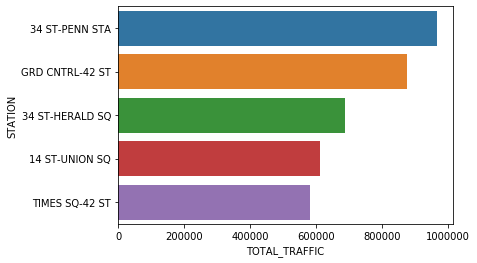

In [149]:
graph_stats(stats)

In [130]:
year18 = main_fun(year18_path_list)

/Users/hi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [131]:
year18

,DATE_TIME,UNIT,SCP,STATION,ENTRIES,EXITS,UNIT/SCP,ENTRIES_DIFF,EXITS_DIFF
0,2018-05-01 00:00:00,R248,00-00-00,1 AV,13478886,15083094,R24800-00-00,0,0
1,2018-05-01 04:00:00,R248,00-00-00,1 AV,13478886,15083094,R24800-00-00,0,0
2,2018-05-01 08:00:00,R248,00-00-00,1 AV,13479249,15084001,R24800-00-00,363,907
3,2018-05-01 12:00:00,R248,00-00-00,1 AV,13480288,15085460,R24800-00-00,1039,1459
4,2018-05-01 16:00:00,R248,00-00-00,1 AV,13481170,15086314,R24800-00-00,882,854
...,...,...,...,...,...,...,...,...,...
704229,2018-05-25 05:00:00,R326,00-05-01,ZEREGA AV,39,103,R32600-05-01,0,0
704230,2018-05-25 09:00:00,R326,00-05-01,ZEREGA AV,39,103,R32600-05-01,0,0
704231,2018-05-25 13:00:00,R326,00-05-01,ZEREGA AV,39,103,R32600-05-01,0,0
704232,2018-05-25 17:00:00,R326,00-05-01,ZEREGA AV,39,103,R32600-05-01,0,0
